In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/pheme/pheme-dataset.csv'
# test_path = '/content/drive/MyDrive/Fakenews/test.csv'

df = pd.read_csv(path)
df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,target
0,0,"Breaking: At least 10 dead, 5 injured after tO...",1
1,1,France: 10 people dead after shooting at HQ of...,1
2,2,Ten killed in shooting at headquarters of Fren...,1
3,3,BREAKING: 10 dead in shooting at headquarters ...,1
4,4,Reuters: 10 people shot dead at headquarters o...,1


In [2]:
print(df.shape)
df.isna().sum()

(1705, 3)


Unnamed: 0    0
text          0
target        0
dtype: int64

,text,target
0,#sydneysiege: Police confirm only one armed su...,1
1,SYDNEY HOSTAGE CRISIS: http://t.co/HFW40OyVUz,1
2,OTTAWA SHOOTING\n- Soldier shot at memorial\n-...,1
3,Black Islamic flag being held up in window of ...,1
4,And now the Trocadero. I have a very bad feeli...,0
...,...,...
1700,Update - AFP reports at least five people have...,1
1701,UPDATE: Security alert in Trocadero near the E...,0
1702,Condolences pour in for family of Cpl. Nathan ...,1
1703,Prince is insulted by Massey Hall's reservatio...,0


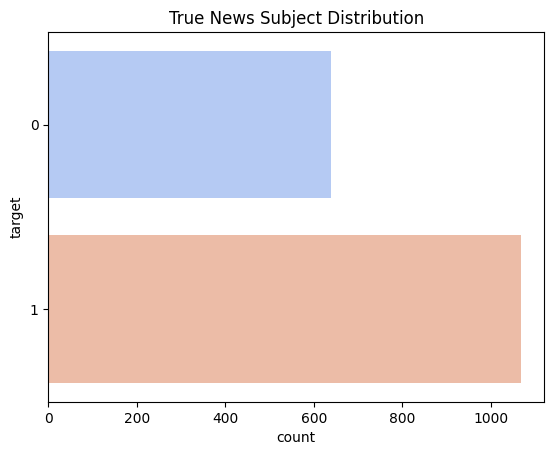

In [3]:
from sklearn.utils import shuffle

df = df[['text','target']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="target", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1705 non-null   object
 1   target  1705 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.8+ KB


In [5]:
df.drop_duplicates(subset=['text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1699 non-null   object
 1   target  1699 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['text'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 1699
Max length of the titles: 18
Mean length of the titles: 10.334902884049441
Median length of the titles: 10.0


In [9]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(list_of_words)

sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
l2_reg = 0.01
optimizer = Adam(lr=0.001)
embedding_vector_features=60
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
# model.add(LSTM(100, return_sequences=True))
model.add(Bidirectional(LSTM(100, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['target'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

In [12]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/10
24/24 [==============================] - 6s 44ms/step - loss: 5.6276 - accuracy: 0.5879 - val_loss: 4.5434 - val_accuracy: 0.7639
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 3.9271 - accuracy: 0.7282 - val_loss: 3.3562 - val_accuracy: 0.8380
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 2.9239 - accuracy: 0.8342 - val_loss: 2.5809 - val_accuracy: 0.8426
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 2.3209 - accuracy: 0.8886 - val_loss: 2.2593 - val_accuracy: 0.8472
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 1.9937 - accuracy: 0.9430 - val_loss: 1.9960 - val_accuracy: 0.8843
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 1.7958 - accuracy: 0.9584 - val_loss: 1.8965 - val_accuracy: 0.8750
Epoch 7/10
24/24 [==============================] - 0s 8ms/step - loss: 1.6545 - accuracy: 0.9705 - val_loss: 1.8384 - val_accuracy: 0.8843
Epoch 8/10
24/24 [=

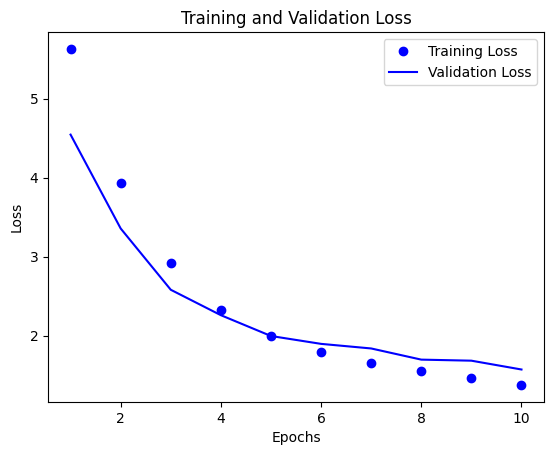

In [13]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 10)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

11/11 [==============================] - 1s 3ms/step
BiLSTM Model Accuracy :  0.8970588235294118
Precision :  0.8928571428571429
Recall :  0.9478672985781991
F1 :  0.9195402298850576
G-mean: 0.8783620518849601
Training time:  7.841699600219727
Inference time:  0.7697920799255371
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       129
           1       0.89      0.95      0.92       211

    accuracy                           0.90       340
   macro avg       0.90      0.88      0.89       340
weighted avg       0.90      0.90      0.90       340



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


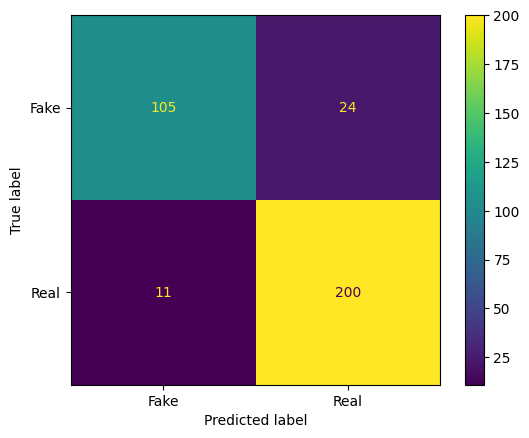

In [14]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()